In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Read CSV file
VT = pd.read_csv("data/processed_VT_Data.csv")

In [3]:
# Set the pandas option to display all columns when printing the DataFrame
pd.set_option('display.max_columns',None)

Target Variable

In [5]:
# Class counts of target variable
class_counts = VT["Training_Program"].value_counts()
VT_class = pd.DataFrame(class_counts).reset_index()
VT_class.columns = ["Training Program", "Count"]
print(VT_class)

   Training Program  Count
0                 0     33
1                 2     30
2                 3     28
3                 1     26
4                 4     23
5                 5     22
6                 6     15
7                 7     14


In [6]:
# Class proportions of target variable
class_proportion = VT["Training_Program"].value_counts(normalize=True).round(2)
VT_class_proportion = pd.DataFrame(class_proportion).reset_index()
VT_class.columns = ["Training Program", "Proportion"]
print(VT_class_proportion)

   Training_Program  proportion
0                 0        0.17
1                 2        0.16
2                 3        0.15
3                 1        0.14
4                 4        0.12
5                 5        0.12
6                 6        0.08
7                 7        0.07


Distribution Analysis

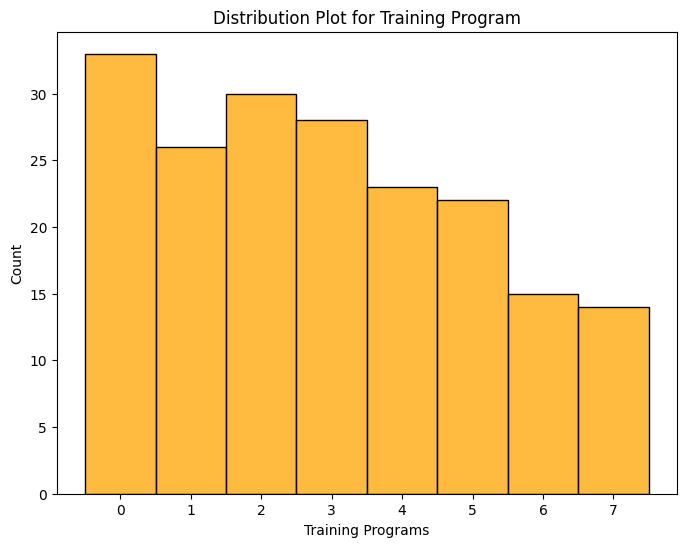

In [8]:
# Distribution plot for target variable
VT['Training_Program'] = VT['Training_Program'].astype('category')
plt.figure(figsize=(8, 6))  
sns.histplot(data=VT, x='Training_Program', kde=False, color='orange') 
plt.title('Distribution Plot for Training Program')
plt.xlabel('Training Programs')
plt.ylabel('Count')

plt.show()

In [9]:
# Remove the categorical variables 
columns_to_plot = VT.drop(columns=["Training_Program","chronic_conditions","surgeries", "gender", "sports_experience", "goals"]).columns
print(columns_to_plot)

Index(['height', 'weight', 'age', 'resting_pulse', 'body_fat', 'BMI',
       'W/Hip_Ratio', 'W/Height_Ratio', 'shoulder_c', 'chest_c', 'right_arm_c',
       'left_arm_c', 'waist_c', 'hip_c', 'upper_leg_c', 'lower_leg'],
      dtype='object')


In [10]:
# Calculate statistics
stats = []
for column in columns_to_plot:
    stats.append({
        "Feature": column,
        "Mean": round(VT[column].mean(), 2),
        "Median": round(VT[column].median(), 2),
        "Std. Dev.": round(VT[column].std(), 2),
        "Min": round(VT[column].min(), 2),
        "Max": round(VT[column].max(), 2),
        "Skewness": round(VT[column].skew(), 2),
        "Kurtosis": round(VT[column].kurtosis(), 2)
    })

# Convert to DataFrame
stats_df = pd.DataFrame(stats)
print(stats_df)


           Feature    Mean  Median  Std. Dev.     Min     Max  Skewness  \
0           height  175.47  177.00       9.27  152.00  206.00     -0.16   
1           weight   81.12   81.00      15.41   43.00  126.00      0.06   
2              age   35.97   35.00       8.98   18.00   69.00      0.74   
3    resting_pulse   73.81   74.00      11.61   46.00  105.00      0.08   
4         body_fat   27.56   27.00       7.97    8.00   50.50      0.25   
5              BMI   26.26   25.61       4.26   15.59   41.41      0.60   
6      W/Hip_Ratio    0.88    0.89       0.09    0.65    1.05     -0.46   
7   W/Height_Ratio    0.52    0.52       0.07    0.35    0.76      0.23   
8       shoulder_c   76.76  107.00      53.51    0.00  142.00     -0.69   
9          chest_c   68.70   96.00      47.82    0.00  126.00     -0.70   
10     right_arm_c   22.32   30.00      15.73    0.00   45.00     -0.63   
11      left_arm_c   22.27   30.50      15.69    0.00   45.00     -0.63   
12         waist_c   90.8

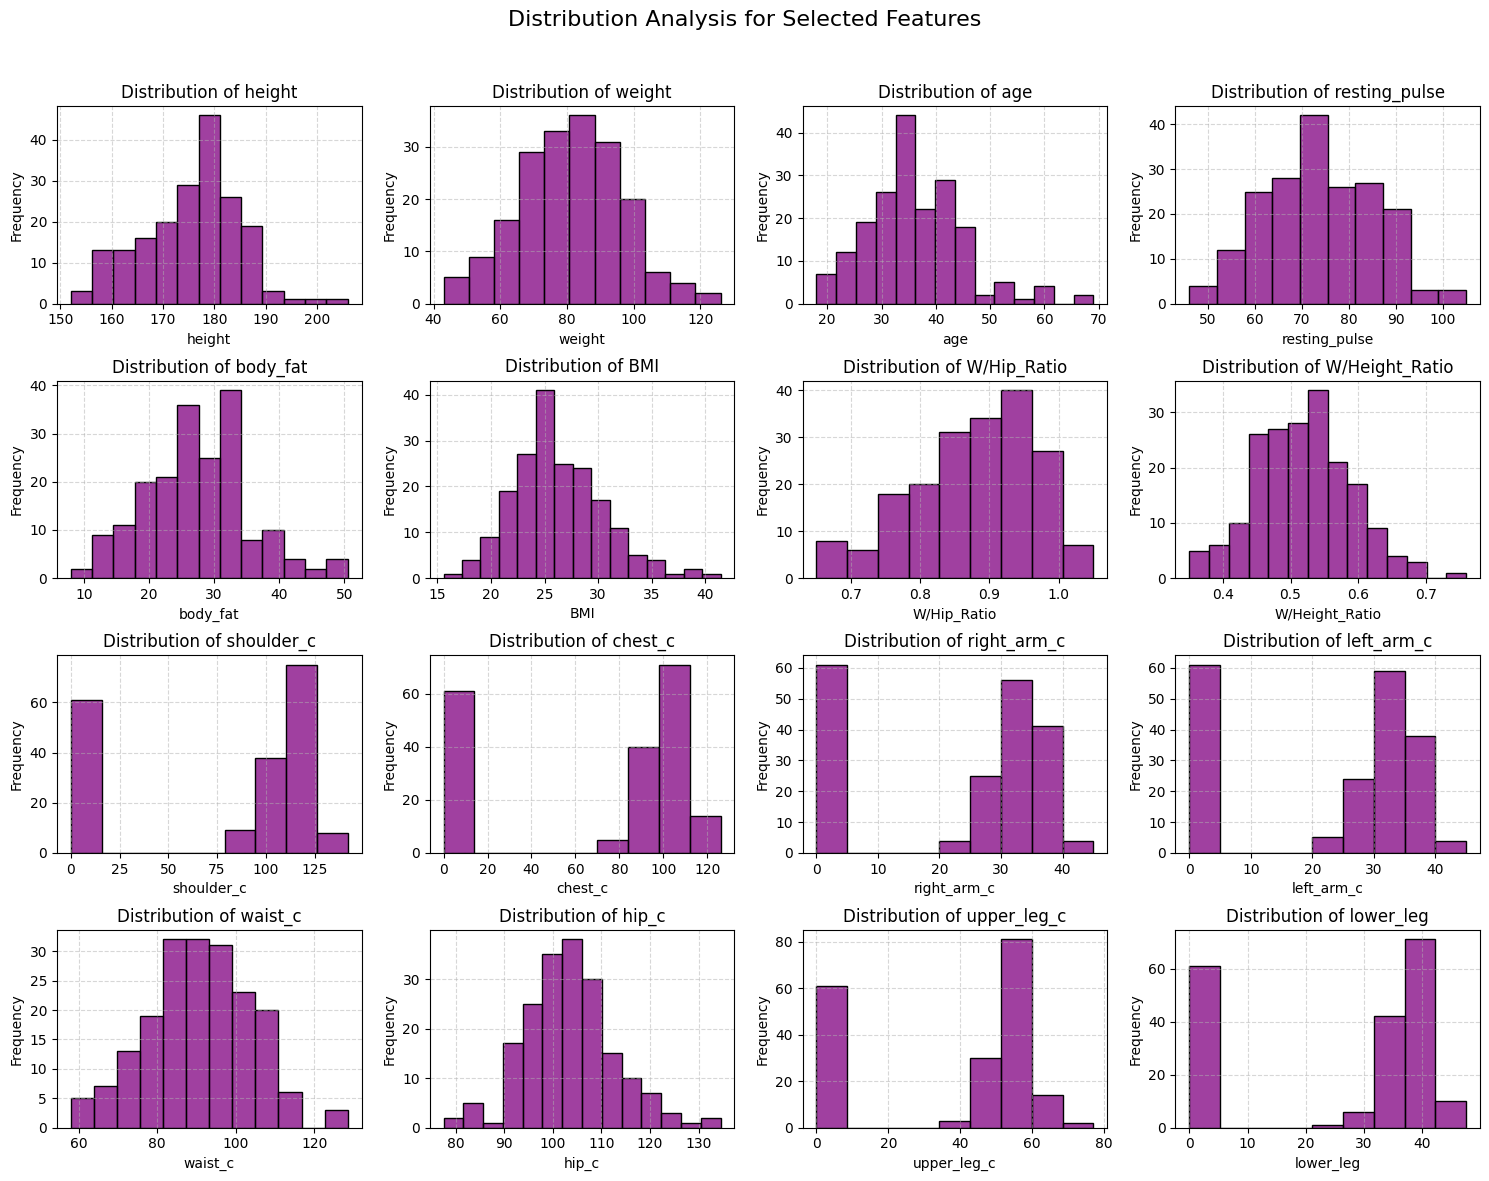

In [173]:
# Calculate the number of rows and columns for the grid of subplots
n_cols = 4  # Number of plots per row
n_rows = (len(columns_to_plot) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Create a figure and a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten() 

# Plot histograms for each column
for i, column in enumerate(columns_to_plot):
    sns.histplot(data=VT, x=column, ax=axes[i], kde=False, color='purple') 
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Remove empty subplots (if any)
for j in range(len(columns_to_plot), len(axes)):
    fig.delaxes(axes[j])

# General title and adjustments
fig.suptitle('Distribution Analysis for Selected Features', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust the top margin for the general title
plt.show()


Correlation Analysis

               Feature  Correlation  P-Value  Corrected P-Value  Significant
0               gender       -0.038    0.600              1.000        False
1               height        0.223    0.002              0.044         True
2               weight       -0.310    0.000              0.000         True
3                  age       -0.120    0.099              1.000        False
4        resting_pulse       -0.580    0.000              0.000         True
5    sports_experience        0.703    0.000              0.000         True
6             body_fat       -0.713    0.000              0.000         True
7                goals       -0.421    0.000              0.000         True
8                  BMI       -0.521    0.000              0.000         True
9          W/Hip_Ratio       -0.242    0.001              0.022         True
10      W/Height_Ratio       -0.616    0.000              0.000         True
11          shoulder_c       -0.182    0.012              0.264        False

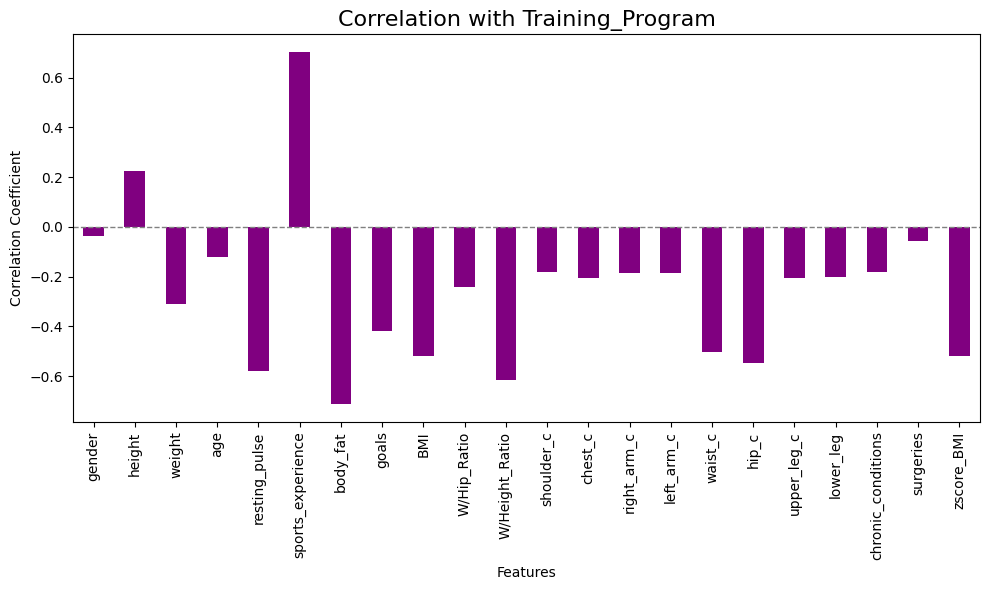

In [49]:
# Calculate correlation and p-values
correlations = []
p_values = []

# Iterate through each column except the target variable itself
for feature in VT.columns:
    if feature != 'Training_Program':
        corr, p_val = pearsonr(VT['Training_Program'], VT[feature])
        correlations.append((feature, round(corr, 3)))  # Round correlation
        p_values.append(round(p_val, 3))  # Round p-value

# Apply Bonferroni correction
_, corrected_p_values, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')
corrected_p_values = [round(p, 3) for p in corrected_p_values]  # Round corrected p-values

# Place correlations and p-values into a DataFrame
correlation_results = pd.DataFrame(correlations, columns=['Feature', 'Correlation'])
correlation_results['P-Value'] = p_values
correlation_results['Corrected P-Value'] = corrected_p_values
correlation_results['Significant'] = correlation_results['Corrected P-Value'] < 0.05

# Print the results
print(correlation_results)

# Visualization
plt.figure(figsize=(10, 6))
correlation_results.set_index('Feature')['Correlation'].plot(kind='bar', color='purple')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title('Correlation with Training_Program', fontsize=16)
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.tight_layout()
plt.savefig('training_program_correlation.png', dpi=300)
plt.show()


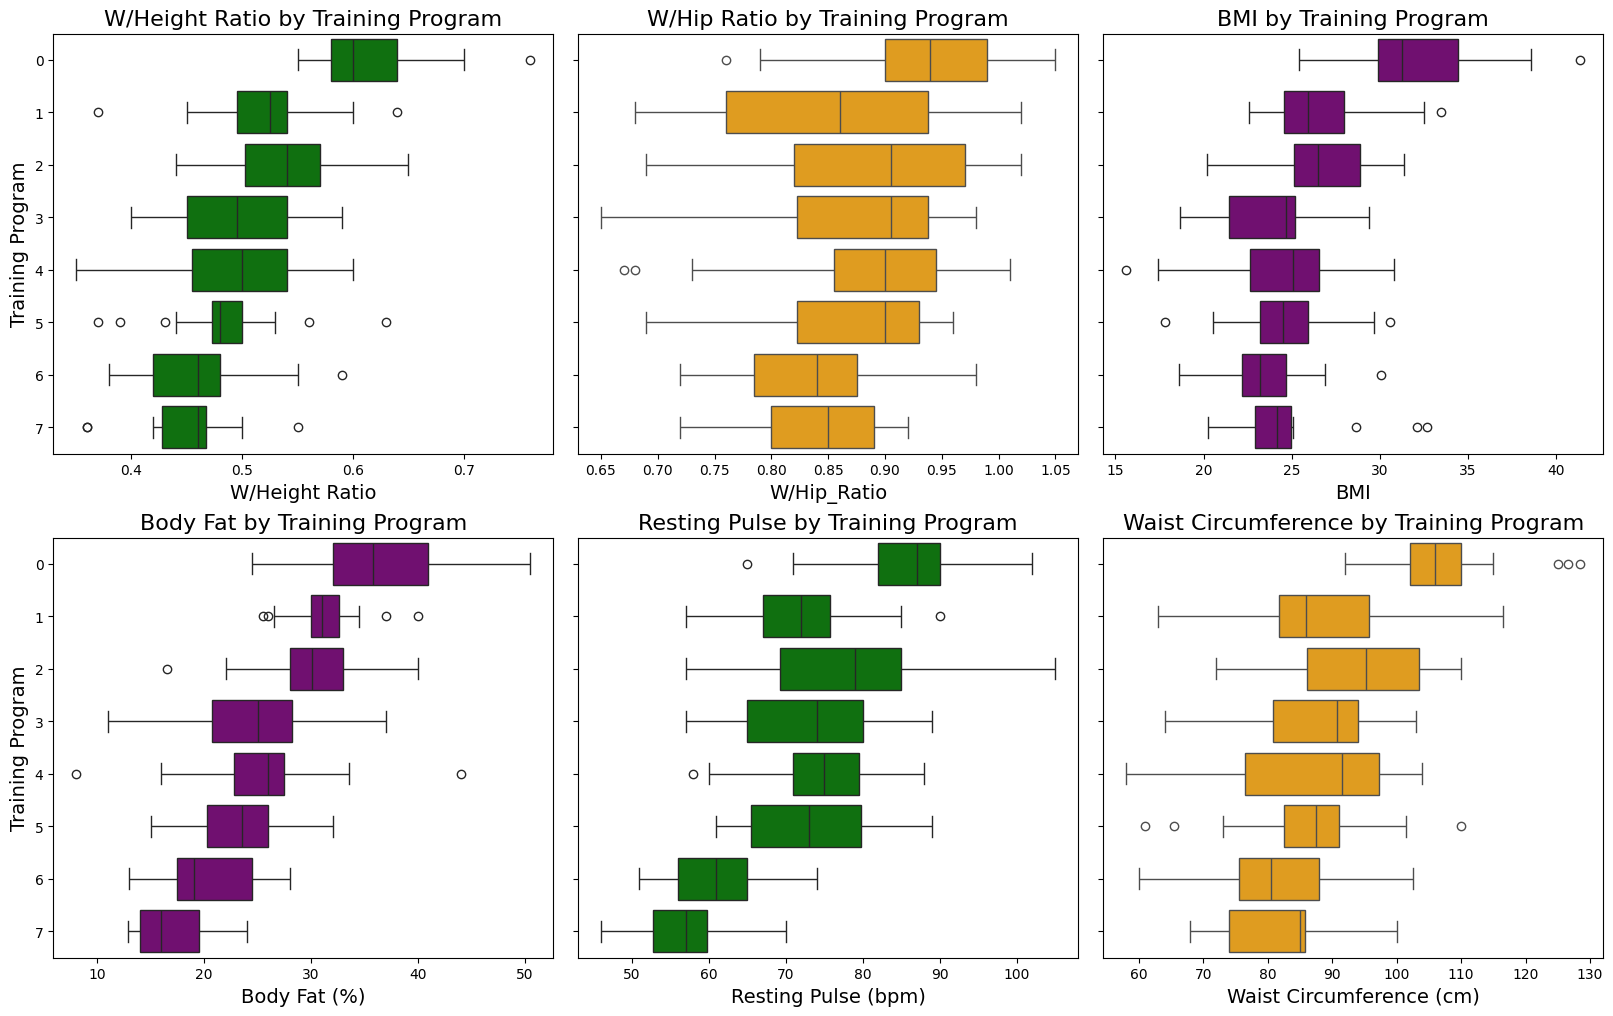

In [167]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharey=True)  # `sharey=True` aligns y-axis

# Boxplot of W/Height Ratio by Training Program
sns.boxplot(ax=axes[0,0], data=VT, x='W/Height_Ratio', y='Training_Program', color="green")
axes[0,0].set_title('W/Height Ratio by Training Program', fontsize=16)
axes[0,0].set_xlabel('W/Height Ratio', fontsize=14)
axes[0,0].set_ylabel('Training Program', fontsize=14)

# Boxplot of W/Hip Ratio by Training Program
sns.boxplot(ax=axes[0,1], data=VT, x='W/Hip_Ratio', y='Training_Program', color="orange")
axes[0,1].set_title('W/Hip Ratio by Training Program', fontsize=16)
axes[0,1].set_xlabel('W/Hip_Ratio', fontsize=14)
axes[0,1].set_ylabel('')  # Remove y-axis label for the second plot

# Boxplot of BMI by Training Program
sns.boxplot(ax=axes[0,2], data=VT, x='BMI', y='Training_Program', color="purple")
axes[0,2].set_title('BMI by Training Program', fontsize=16)
axes[0,2].set_xlabel('BMI', fontsize=14)
axes[0,2].set_ylabel('Training Program', fontsize=14) # Remove y-axis label for the third plot

# Boxplot of Body Fat by Training Program
sns.boxplot(ax=axes[1,0], data=VT, x='body_fat', y='Training_Program', color="purple")
axes[1,0].set_title('Body Fat by Training Program', fontsize=16)
axes[1,0].set_xlabel('Body Fat (%)', fontsize=14)
axes[1,0].set_ylabel('Training Program', fontsize=14)

# Boxplot of Resting Pulse by Training Program
sns.boxplot(ax=axes[1,1], data=VT, x='resting_pulse', y='Training_Program', color="green")
axes[1,1].set_title('Resting Pulse by Training Program', fontsize=16)
axes[1,1].set_xlabel('Resting Pulse (bpm)', fontsize=14)
axes[1,1].set_ylabel('')  # Remove y-axis label for the second plot

# Boxplot of Waist Circumference by Training Program
sns.boxplot(ax=axes[1,2], data=VT, x='waist_c', y='Training_Program', color="orange")
axes[1,2].set_title('Waist Circumference by Training Program', fontsize=16)
axes[1,2].set_xlabel('Waist Circumference (cm)', fontsize=14)
axes[1,2].set_ylabel('')  # Remove y-axis label for the third plot

# Adjust layout for better spacing
plt.subplots_adjust(wspace=0.05) 
plt.show()


Text(0, 0.5, 'Count')

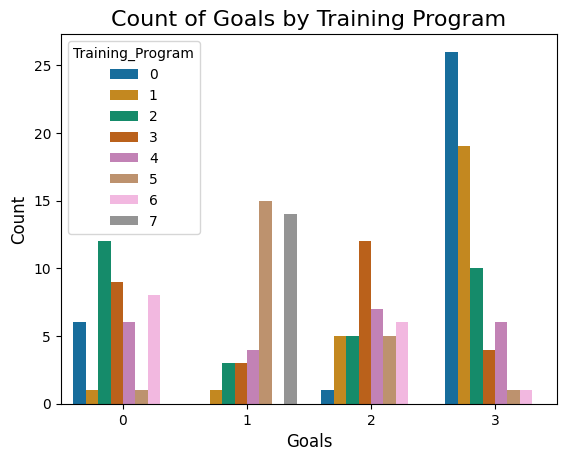

In [14]:
# Countplot for Goals by Training Program with colorblind-friendly palette
sns.countplot(data=VT, x='goals', hue='Training_Program', palette="colorblind")
plt.title('Count of Goals by Training Program', fontsize=16) # Add title and axis labels
plt.xlabel('Goals', fontsize=12)
plt.ylabel('Count', fontsize=12)

<Axes: xlabel='W/Height_Ratio', ylabel='resting_pulse'>

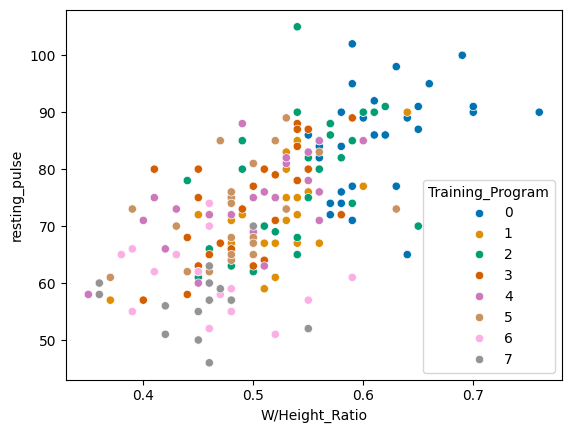

In [17]:
# Create a scatter plot for visualizing interaction of Waist-to-Height Ratio by Resting pulse on class categories
sns.scatterplot(data=VT, x='W/Height_Ratio', y='resting_pulse', hue='Training_Program', palette="colorblind")

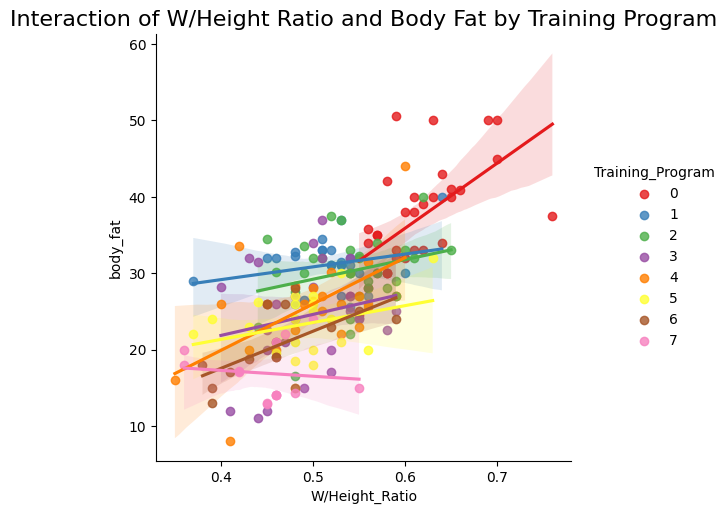

In [66]:
# Create a scatter plot with regression lines to show the interaction between W/Height Ratio and Body Fat, by Training Program
sns.lmplot(data=VT, x='W/Height_Ratio', y='body_fat', hue='Training_Program', scatter=True, palette='Set1')
plt.title('Interaction of W/Height Ratio and Body Fat by Training Program', fontsize=16)
plt.show()
